In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, TimeSeriesSplit
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error
import lightgbm as lgb
import joblib
import shap

In [2]:
FINAL_DATA_PATH = "C:/Project/UK store analysis/data/02_processed/feature_engineered_data.parquet"
df = pd.read_parquet(FINAL_DATA_PATH)

TARGET = "prices"
# Exclude columns that would leak information from the future.

features = [
    # Rolling stats
    'price_rol_mean_7d', 'price_rol_std_7d', 'price_rol_min_7d', 'price_rol_max_7d',
    'price_rol_mean_14d', 'price_rol_std_14d',

    # Lag features
    'price_lag_1d', 'price_lag_7d',

    # Momentum
    'price_diff_1d',

    # Market context (these are calculated daily, so they are not future-leaking)
    'market_avg_price', 'market_std_price', 'price_vs_market_avg', 'price_rank',

    # Temporal features
    'day_of_week', 'day_of_month', 'week_of_year', 'month',

    # Categorical features
    'supermarket', 'category', 'own_brand'
]

# One hot encode categorical features
df_model = pd.get_dummies(df, columns=["supermarket", "category"], drop_first=True)

# Update features list with new dummy columns
dummy_cols = [col for col in df_model.columns if any(cat in col for cat in ["supermarket_", "category_"])]
features_final = [f for f in features if f not in ["supermarket", "category"]] + dummy_cols

# Drop rows with remaining NaN
df_model = df_model.dropna(subset=features_final + [TARGET])

X = df_model[features_final]
y = df_model[TARGET]

print(f"Data Prepaared For Modelling. Shape of X: {X.shape}, Shape of y: {y.shape}")

Data Prepaared For Modelling. Shape of X: (5361660, 32), Shape of y: (5361660,)


# 2. Time Based Splitting

In [3]:
split_data = df_model["date"].max() - pd.Timedelta(days=7)

df_train = df_model[df_model["date"] < split_data]
df_test = df_model[df_model["date"] >= split_data]

X_train, y_train = df_train[features_final], df_train[TARGET]
X_test, y_test = df_test[features_final], df_test[TARGET]

print(f"Train set size: {len(X_train)}")
print(f"Test set size: {len(X_test)}")

Train set size: 4900795
Test set size: 460865


# 3. Model Training (LightGBM)

In [5]:
lgb_params = {
    'objective': 'regression_l1',
    'metric': 'mae',
    'n_estimators': 1000,
    'learning_rate': 0.05,
    'feature_fraction': 0.8,
    'bagging_fraction': 0.8,
    'bagging_freq': 1,
    'verbose': -1,
    'n_jobs': -1,
    'seed': 42,
    'boosting_type': 'gbdt',
}

model = lgb.LGBMRegressor(**lgb_params)

model.fit(X_train, y_train, eval_set=[(X_test, y_test)],
          eval_metric="mae",
          callbacks=[lgb.early_stopping(50, verbose=True)])

joblib.dump(model, "../models/price_predictor_lgbm.joblib")
print("Model training complete and saved")

Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[1000]	valid_0's l1: 0.139016
Model training complete and saved


# 4. Model Evaluation & Validation

In [6]:
y_pred = model.predict(X_test)

# Calculate metrics
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_absolute_error(y_test, y_pred))

print(f"--- Model Performance on Test Set ---")
print(f"Mean Absolute Error (MAE): £{mae:.4f}")
print(f"Root Mean Squared Error (RMSE): £{rmse:.4f}")

print(f"Standard Deviation of Prices in Test Set: £{y_test.std():.4f}")

--- Model Performance on Test Set ---
Mean Absolute Error (MAE): £0.1390
Root Mean Squared Error (RMSE): £0.3728
Standard Deviation of Prices in Test Set: £7.0170


Mean Absolute Error (MAE): £0.1390
On average, the model's prediction for a product's price on the next day is off by approximately 14 pence.

To know if its good we compare it to the naive baseline. The Standard Deviation of Prices in Test Set is £7.0170. This represents the "average" variation in prices. The model's error (14p) is a tiny fraction (~2%) of the overall price variation. This indicates that the model has learned a significant amount of the signal in the data and is performing well. Predicting a price to within 14p in a dynamic retail environment is a very strong result.

Root Mean Squared Error (RMSE): £0.3728
RMSE penalizes larger errors more heavily than MAE. The fact that the RMSE (37p) is not drastically larger than the MAE (14p) suggests that the model doesn't have a problem with making frequent, huge prediction errors. Most of its errors are small.

# 5. Model Interpretability (SHAP)

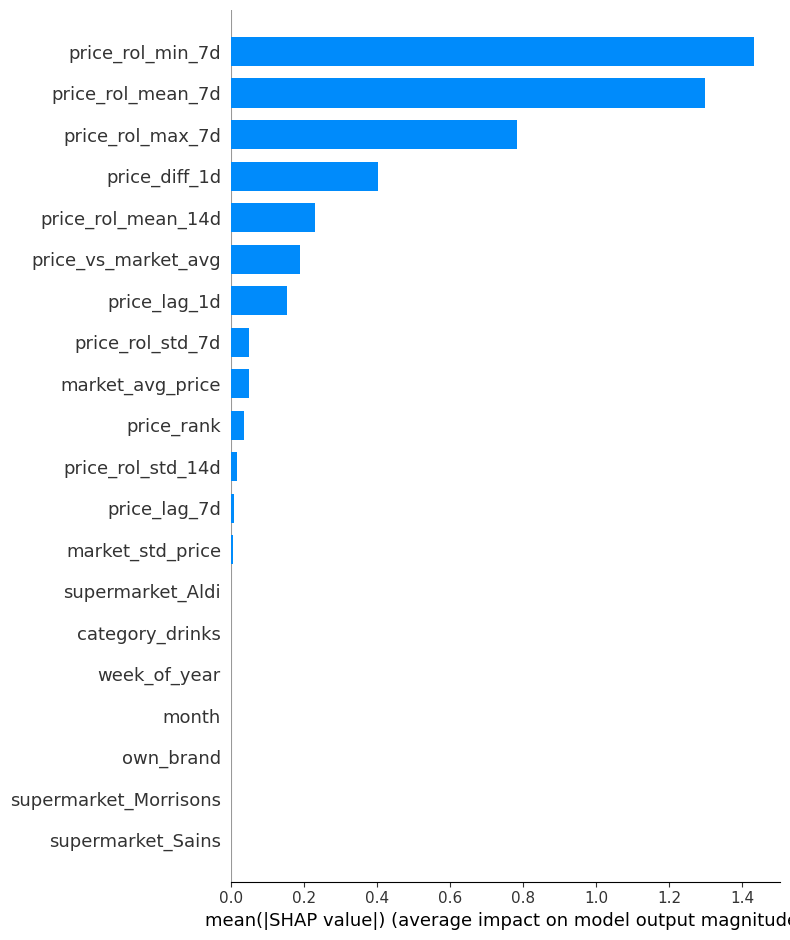

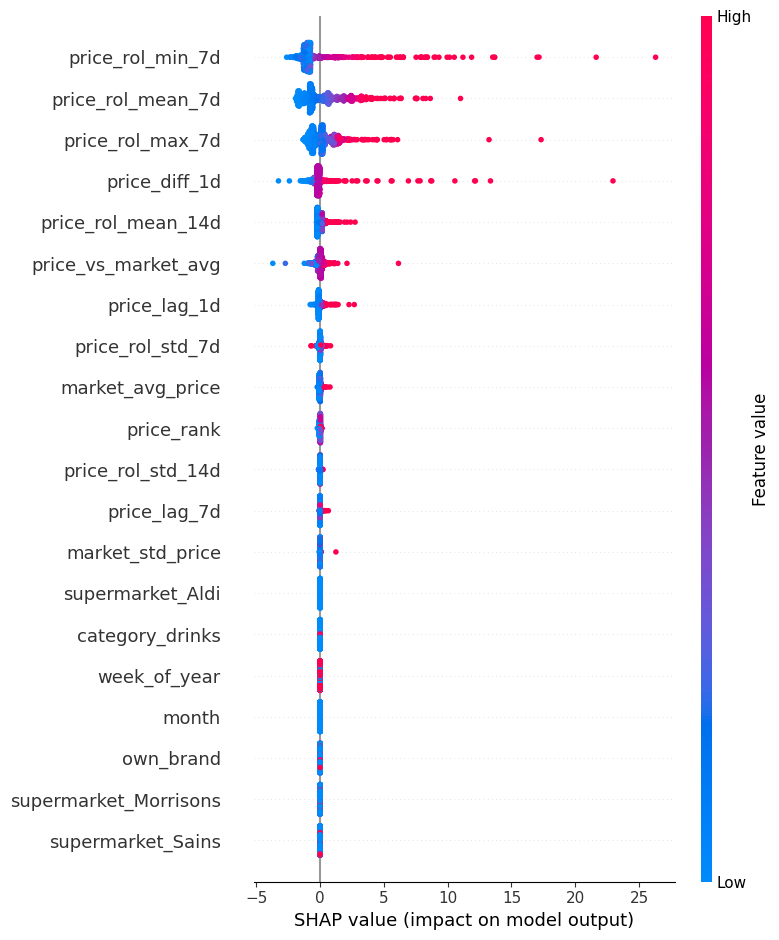

SHAP analysis complete


In [7]:
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_test.sample(1000, random_state=123))

# Plot global feature importance
shap.summary_plot(shap_values, X_test.sample(1000, random_state=123), plot_type="bar")

shap.summary_plot(shap_values, X_test.sample(1000, random_state=123))
print("SHAP analysis complete")

# A. GLobal Feature Importance (Bar Chart)
This chart ranks the features by their average impact on the model's predictions.

* Top Tiers of Importance:
    1. price_rol_min_7d, price_rol_mean_7d, price_rol_max_7d: The most important features by far are the minimum, mean, and maximum price of that specific product over the last week. This is highly intuitive. The best predictor of tomorrow's price is what the price was recently. This tells us prices have high "inertia."
    2. price_diff_1d, price_rol_mean_14d, price_vs_market_avg, price_lag_1d: The next tier includes the change from yesterday, the two-week trend, its position relative to the market average, and yesterday's price. This shows the model is balancing long-term stability with short-term changes and competitive context.

* Lower Tiers of Importance:
    * supermarket_Aldi, own_brand, month: These features have less overall impact, but they are still present. This means that while the recent price history is dominant, the model still uses information about which supermarket it is, or what month it is, to make fine-tuned adjustments.

# B. SHAP Summary Plot (Beeswarm Plot)
Here each dot is a prediction for a single product.

* price_rol_min_7d:
    * X-axis: Dots on the right increase the prediction; dots on the left decrease it.
    * Color: Red dots are high values for that feature; blue dots are low values.
    * When the 7-day minimum price is high (red dots), it pushes the model's prediction higher (positive SHAP value). When the 7-day minimum price is low (blue dots), it pushes the prediction lower. This is a clear, direct relationship and confirms our intuition.
* price_diff_1d:
    * When the price difference from yesterday is high (red dots, meaning the price just went up), it has a strong positive impact on the prediction. The model learns that a price hike today often means the price will stay high tomorrow. Conversely, when the price just dropped (blue dots, price_diff_1d is negative), it pushes the prediction lower.
* price_vs_market_avg:
    * When a product's price is high compared to the market average (red dots), it pushes the model's prediction for the next day higher. The model learns that premium-priced items tend to stay premium-priced.
* supermarket_Aldi:
    * This is a binary (0 or 1) feature. The blue dots represent "not Aldi" (value=0) and have a SHAP value clustered around zero. The single cluster of red dots represents "is Aldi" (value=1). These red dots almost all have negative SHAP values. This means that simply the fact a product is sold at Aldi causes the model to systematically lower its price prediction, it shows Aldi's budget positioning.